# Introduction 

This is a project where we will be performing analysis on tesla stock data as well as predicting future stock prices. 

# Library Imports 

In [119]:
import os 
import zipfile

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Data Ingestion
 
Reading in data from a .zip file. 
First step is to unzip file then access the csv file 

In [76]:
#first check if the file alrady exists or not 

if not(os.path.exists("TSLA.csv")):
    #unzip and read in data 
    zip_filename = "tesla_stock_data.zip"
    # zip_file_loc = os.path.dirname(zip_filename)

    with zipfile.ZipFile(zip_filename, 'r') as f:
        f.extractall()
        print("Zip file has been extracted")

else:
    print("Extracted file is present in directory")

Extracted file is present in directory


# Data Exploration 

Exploring the data and the various central tendencies

In [77]:
data = pd.read_csv('TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [78]:
#check data categories
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


In [79]:
#check data statistics
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


Data may need to be normalized and scaled down

In [80]:
data.columns.tolist()

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

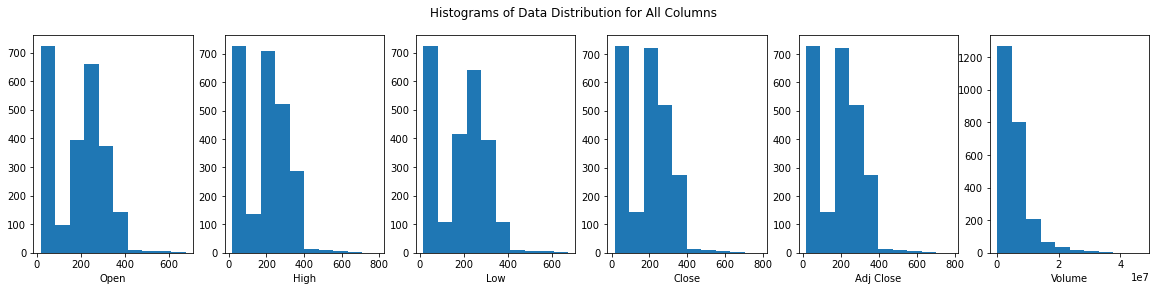

In [81]:
#plot data distributions for all the features 
figure, axis = plt.subplots(nrows=1, ncols=len(data.columns)-1, figsize=(20, 4))

col_list = data.columns.tolist()
#we omit the date variable from the plot 
for i in range(1, len(col_list)):
    axis[i-1].hist(data[f"{col_list[i]}"], label=f"{col_list[i]} Dist")
    axis[i-1].set_xlabel(f"{col_list[i]}")

figure.suptitle('Histograms of Data Distribution for All Columns')
plt.show()

From the above data distributions we can see that the variables are skewed towards the right with the most skewed variable being 'Volume'. This will be crucial information and will play a part in deciding how to deal with any missing values that are encountered for any of the variables

In [82]:
#check for missing values by column 
(data.isnull().sum()/len(data))*100

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

In this dataset there are no missing values

# Feature Engineering 

In [83]:
#normalization ? - do through scaling or log ?


In [84]:
#converting the data column to datetime values for a closer look at the relationship with other features 
data['Date'] = pd.to_datetime(data['Date'])

In [85]:
data["Date"]

0      2010-06-29
1      2010-06-30
2      2010-07-01
3      2010-07-02
4      2010-07-06
          ...    
2411   2020-01-28
2412   2020-01-29
2413   2020-01-30
2414   2020-01-31
2415   2020-02-03
Name: Date, Length: 2416, dtype: datetime64[ns]

In [86]:
data["Date"].max() - data["Date"].min()

Timedelta('3506 days 00:00:00')

In [87]:
data['year'] = pd.to_datetime(data['Date']).dt.year
data['month'] = pd.to_datetime(data['Date']).dt.month

data['year_month'] = data['Date'].dt.strftime('%Y-%m')

<Figure size 1440x7200 with 0 Axes>

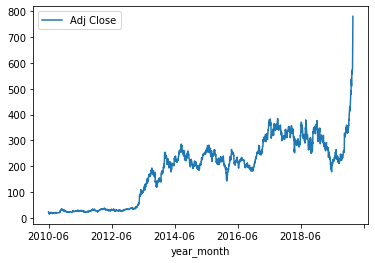

In [88]:
#make a line graph of the date against the other features/variables 
plt.figure(figsize=(20, 100))
data.plot(x="year_month", y="Adj Close", kind="line")
plt.show()

### Adj Close vs Close 

Here we will need to select the target variable for the linear regression. We have two options, 'Close' and 'Adjusted Close'. 
- 'Close' indicates the closing price of the stock. It is the final price at which a stock is traded on a give day 
- 'Adjusted Close' indicates the closing price of the stock <b>after</b> it has been adjusted for other corporate factors such as dividends, stock splits etc. 

I have decided to use Adjusted Close since it reflects the true value of the stock price according to the definitions (referenced from <a href="https://www.investopedia.com/terms/a/adjusted_closing_price.asp">this link</a>)

In [89]:
#drop the 'close' variable as it will cause a data leakage when carrying out predictions with the adj close as the target variable 

data = data.drop(["Close"], axis=1)

In [90]:
data

,Date,Open,High,Low,Adj Close,Volume,year,month,year_month
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,2010,6,2010-06
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,2010,6,2010-06
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,2010,7,2010-07
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,2010,7,2010-07
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,2010,7,2010-07
...,...,...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,11788500,2020,1,2020-01
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,17801500,2020,1,2020-01
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,29005700,2020,1,2020-01
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,15719300,2020,1,2020-01


In [91]:
#make a feature set 
X = data.loc[:, ~data.columns.isin(["Adj Close", "Date", "year", "month", "year_month"]) ]

#make a target variable 
y = data["Adj Close"]

### Correlation Analysis

In [92]:
data_edited = data.loc[:, ~data.columns.isin(["Date", "year", "month", "year_month"]) ]

<AxesSubplot:>

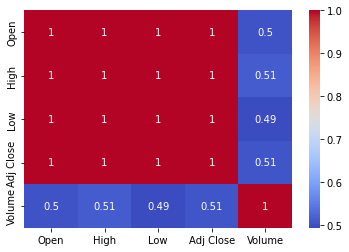

In [93]:
corr_matrix = data_edited.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Volume shows the least correlation with the target variable

# Model Training 

Here we are going to build a linear regression model 

In [94]:
#split data into test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [95]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

We will built a model using the concept of Gradient Descent (idea is to tweak params to reduce cost function)

In [96]:
#using batch gradient descent 
#note: there is no single way to do batch gradient directly. instead we apply the param : 'batch_size' which effectively turns the SGDRegressor into batch gd
bgd_reg = SGDRegressor(loss='squared_error', penalty=None, max_iter=1000, learning_rate='constant', eta0=0.01, random_state=0)
bgd_reg.fit(X_train, y_train)

SGDRegressor(learning_rate='constant', penalty=None, random_state=0)

In [97]:
#simulating a sgd 
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=0)
sgd_reg.fit(X_train, y_train.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=0)

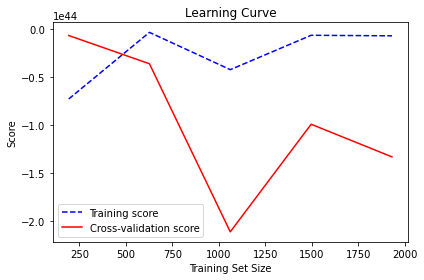

In [98]:
#plot learning curve 

# Generate learning curves using the learning_curve() function
train_sizes, train_scores, test_scores = learning_curve(sgd_reg, X, y, cv=5)

# Calculate the mean and standard deviation of the training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.plot(train_sizes, train_mean, '--', color="blue", label="Training score")
plt.plot(train_sizes, test_mean, color="red", label="Cross-validation score")
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [99]:
#check mse
lin_reg_pred = lin_reg.predict(X_test)
mse_lin_reg = mean_squared_error(y_test, lin_reg_pred)

bgd_reg_pred = bgd_reg.predict(X_test)
mse_bgd_reg = mean_squared_error(y_test, bgd_reg_pred)

sgd_reg_pred = sgd_reg.predict(X_test)
mse_sgd_reg = mean_squared_error(y_test, sgd_reg_pred)

print(f"Linear Regression:  {mse_lin_reg}\nBatch Gradient Descent Regression:  {mse_bgd_reg}\nStochastic Gradient Descent Regression:  {mse_sgd_reg}\n")

Linear Regression:  4.309970349288735
Batch Gradient Descent Regression:  5.187356600255815e+46
Stochastic Gradient Descent Regression:  1.1777094412310656e+46



In [102]:
# trying out ridge regression : regularization is added to the cost function. This forces the model to keep the weights as small as possible 
#alpha value -> regularization control 

ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X_train, y_train)


Ridge(alpha=1, solver='cholesky')

In [104]:
ridge_reg_pred = ridge_reg.predict(X_test)
mse_ridge_reg = mean_squared_error(y_test, ridge_reg_pred)
print(f"Ridge Regression MSE: {mse_ridge_reg}")

Ridge Regression MSE: 4.310086665441125


In [117]:
#lasso regression. It sets weights of the least important features to 0 
lasso_reg = Lasso(alpha=0.0001, max_iter=1000000, random_state=0)
lasso_reg.fit(X_train, y_train)

lasso_reg_pred = lasso_reg.predict(X_test)
mse_lasso_reg = mean_squared_error(y_test, lasso_reg_pred)
print(f"Lasso Regression MSE: {mse_lasso_reg}")

Lasso Regression MSE: 4.30998629186402


In [128]:
#best performing model was sgd so we are going to select that model and work on improving it 
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l1', 'l2'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

# Create the SGDRegressor model
mod_sgd = SGDRegressor(random_state=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=mod_sgd, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'alpha': 0.001, 'learning_rate': 'adaptive', 'penalty': 'l2'}
Best Score: -4.542690439774974e+39


In [130]:
mod_sgd = SGDRegressor(alpha= 0.001, learning_rate= 'adaptive', penalty= 'l2', random_state=0)
mod_sgd.fit(X_train, y_train)
mod_sgd_pred = mod_sgd.predict(X_test)
mse_mod_sgd = mean_squared_error(y_test, mod_sgd_pred)
print(mse_mod_sgd)

8.07334409342447e+38
